In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
ames = pd.read_csv("/content/drive/My Drive/AmesHousing.csv")

In [5]:
ames.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [6]:
# Get rid of columns with mostly NaN values
good_cols = ames.isna().sum() < 100
ames = ames.loc[:,good_cols]

# Drop other NAs
ames = ames.dropna()

In [27]:
X = ames.drop(["SalePrice", "Order", "PID"], axis = 1)
y = ames["SalePrice"]


ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'), # Function of step
    make_column_selector(dtype_include=object)), # Grab all strings
    ("standardize", # Choosing datasets
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

In [28]:
scores = cross_val_score(lr_pipeline_1, X, y, cv = 5, scoring = 'r2')
scores.mean()

-4.0294041643340005e+20

Make a pipeline that uses all the variables in the Ames dataset, and then fits Ridge Regression with .

Cross-validate this pipeline and compare the results to the ordinary linear regression.

Then fit the model on the whole dataset and get the coefficients. Make a plot of these coefficients compared to the ones from ordinary linear regression.

In [20]:
X = ames.drop(["SalePrice", "Order", "PID"], axis = 1)
y = ames["SalePrice"]


ct = ColumnTransformer(
  [
    ("dummify", # name of step
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'), # Function of step
    make_column_selector(dtype_include=object)), # Grab all strings
    ("standardize", # Choosing datasets
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

ridge_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha=1))]
)

In [21]:
scores = cross_val_score(ridge_pipeline_1, X, y, cv = 5, scoring = 'r2')
scores.mean()

0.8611593144036662

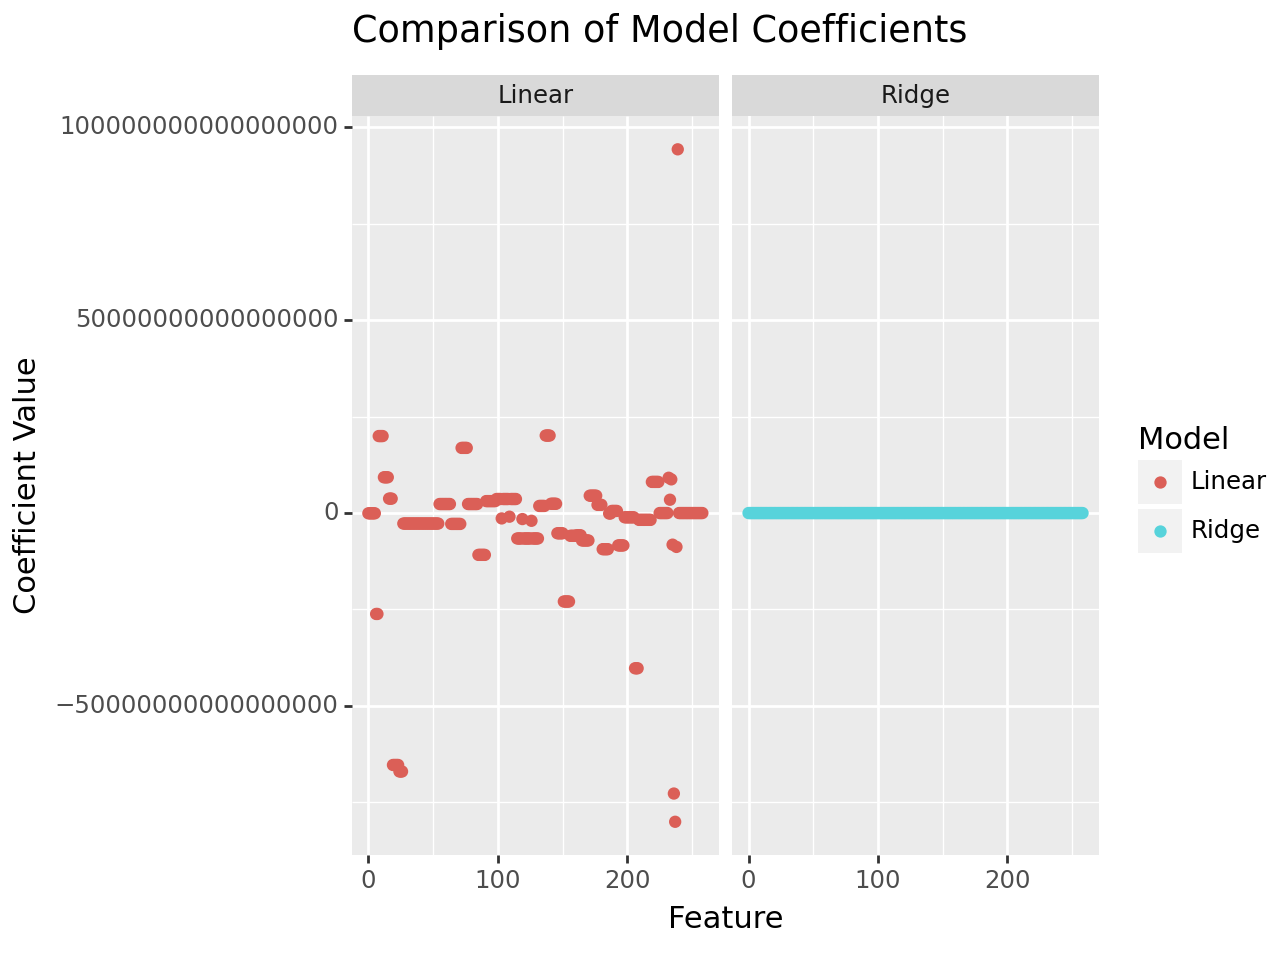

<Figure Size: (640 x 480)>

In [11]:
from plotnine import ggplot, aes, geom_point, labs, geom_bar, facet_wrap

ridge_pipeline_1.fit(X, y)
ridge_coefs = ridge_pipeline_1.named_steps['ridge_regression'].coef_

lr_pipeline_1.fit(X, y)
linear_coefs = lr_pipeline_1.named_steps['linear_regression'].coef_

coefs_df = pd.DataFrame({
    'Ridge': ridge_coefs,
    'Linear': linear_coefs,
    'Feature': range(len(ridge_coefs))
})

coefs_df = pd.DataFrame({
    'Coefficient Value': np.concatenate((ridge_coefs, linear_coefs)),
    'Model': ['Ridge'] * len(ridge_coefs) + ['Linear'] * len(linear_coefs),
    'Feature': list(range(len(ridge_coefs))) + list(range(len(linear_coefs)))
})

# Plot using plotnine
plot = (ggplot(coefs_df, aes(x='Feature', y='Coefficient Value', color='Model')) +
        geom_point() +
        labs(x='Feature', y='Coefficient Value', title='Comparison of Model Coefficients') +
        facet_wrap('Model'))
plot

Using the same pipeline as previously, perform tuning on Lambda
.

You should always try Lambda values on a log scale; that is, don’t use [1,2,3,4]; instead use something like [0.001, 0.01, 0.1, 1, 10]

In [22]:
from sklearn.model_selection import GridSearchCV

results = [.001,.01,.1,1,10,100]

lambdas = {'ridge_regression__alpha': results}

gscv = GridSearchCV(ridge_pipeline_1, lambdas, cv = 5, scoring='r2')

In [23]:
scores = cross_val_score(ridge_pipeline_1, X, y, cv = 5, scoring = 'r2')
scores.mean()

0.8611593144036662

Create a LASSO pipeline, and tune Lambda.

Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS

In [24]:
lasso_pipeline = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso())]
)

In [25]:
scores = cross_val_score(lasso_pipeline, X, y, cv = 5, scoring = 'r2')
scores.mean()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.688e+10, tolerance: 1.474e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.393e+10, tolerance: 1.463e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.582e+10, tolerance: 1.477e+09


0.8558900650255857

The R2 value for OLS was extremely small, so this pipeline, with R2 value of 0.856 clearly outperforms it.  On the other hand it does not outperform the Ridge pipeline with an R2 of 0.861.

Create an Elastic Net pipeline, and tune Lambda and Alpha.

Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS.

In [17]:
elastic_pipeline = Pipeline([
    ('preprocessing', ct),
    ('elasticnet', ElasticNet())
])

In [26]:
scores = cross_val_score(elastic_pipeline, X, y, cv = 5, scoring = 'r2')
scores.mean()

0.8306163198059204

The R2 value for OLS was extremely small, so this pipeline, with R2 value of 0.831 clearly outperforms it.  On the other hand it does not outperform the Ridge pipeline with an R2 of 0.861.